In [1]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py

import obspy
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
import scipy
from scipy import signal
from scipy.signal import butter, filtfilt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader




# Add custom module path
module_path = os.path.abspath(os.path.join('scripts'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
    
from neural_network_architectures import (
    QuakeXNet_1d, QuakeXNet_2d, SeismicCNN_1d, SeismicCNN_2d
)

from helper_functions import extract_spectrograms

# IRIS client instance
client = Client('IRIS')

from typing import Any

from scipy.signal import correlate




cuda
cuda


In [2]:
# ====================
# 1. Model Setup Parameters
# ====================
# Fixed parameters for the models (do not change)
num_channels = 3        # Number of input channels (seismic data)
dropout = 0.9           # Dropout rate to prevent overfitting

# Set device to GPU if available, else use CPU
device = "cuda"     #torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ============================
# 2. Model Initialization
# ============================
# Initialize models with the number of classes, channels, and dropout rate
model_seismiccnn_1d = SeismicCNN_1d(num_classes=4, num_channels=num_channels, dropout_rate=dropout).to(device)
model_seismiccnn_2d = SeismicCNN_2d(num_classes=4, num_channels=num_channels, dropout_rate=dropout).to(device)
model_quakexnet_1d = QuakeXNet_1d(num_classes=4, num_channels=num_channels, dropout_rate=dropout).to(device)
model_quakexnet_2d = QuakeXNet_2d(num_classes=4, num_channels=num_channels, dropout_rate=dropout).to(device)

# ============================
# 3. Load Pretrained Weights
# ============================
# Load the pretrained model state dictionaries from saved files
saved_model_seismiccnn_2d = torch.load('trained_models/best_model_SeismicCNN_2d.pth', map_location=device)
saved_model_quakexnet_2d = torch.load('trained_models/best_model_QuakeXNet_2d.pth', map_location=device)
saved_model_quakexnet_1d = torch.load('trained_models/best_model_QuakeXNet_1d.pth', map_location=device)
saved_model_seismiccnn_1d = torch.load('trained_models/best_model_SeismicCNN_1d.pth', map_location=device)

# ============================
# 4. Load Weights into Models
# ============================
# Load the state dictionaries into the corresponding models
model_seismiccnn_1d.load_state_dict(saved_model_seismiccnn_1d)
model_seismiccnn_2d.load_state_dict(saved_model_seismiccnn_2d)
model_quakexnet_1d.load_state_dict(saved_model_quakexnet_1d)
model_quakexnet_2d.load_state_dict(saved_model_quakexnet_2d)


# ============================
# 5. Set Models to Evaluation Mode
# ============================
# Move models to evaluation mode (important for layers like dropout and batch norm)
model_seismiccnn_1d.eval()
model_seismiccnn_2d.eval()
model_quakexnet_1d.eval()
model_quakexnet_2d.eval()

# ============================
# 6. Move Models to Correct Device
# ============================
# Ensure all models are on the correct device (GPU or CPU)
model_seismiccnn_1d.to(device)
model_seismiccnn_2d.to(device)
model_quakexnet_1d.to(device)
model_quakexnet_2d.to(device)


/tmp/ipykernel_165984/2645211226.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_model_seismiccnn_2d = torch.load('trained_models/best_model_SeismicCNN_2d.pth', m

QuakeXNet_2d(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5): Bat

## Loading the dataset

In [3]:
# Helper function to load and filter metadata
def load_filtered_metadata(path, channel="BH", source_type=None):
    df = pd.read_csv(path)
    df = df[df["station_channel_code"] == channel]
    if source_type:
        df = df[df["source_type"] == source_type]
    return df

# Paths
base_path = "/data/whd01/yiyu_data/PNWML"
exotic_path = f"{base_path}/exotic_metadata.csv"
noise_path = f"{base_path}/noise_metadata.csv"
comcat_path = f"{base_path}/comcat_metadata.csv"

# Load filtered datasets
exotic = load_filtered_metadata(exotic_path, source_type="surface event")
noise = load_filtered_metadata(noise_path, source_type="noise")
comcat = load_filtered_metadata(comcat_path)

# Split comcat into earthquake and explosion
eq = comcat[comcat["source_type"] == "earthquake"]
exp = comcat[comcat["source_type"] == "explosion"]


noise = noise[0:200]
exotic = exotic[0:200]
eq = eq[0:200]
exp = exp[0:200]

#Now concatenate all of them into one DataFrame#
combined_df = pd.concat([noise, exotic, eq, exp], ignore_index=True)

## Local version

In [4]:
event = exotic.iloc[3]
network = event["station_network_code"]
station = event["station_code"]
channel = event["station_channel_code"]
starttime = obspy.UTCDateTime(event["trace_start_time"])
print(event)

event_id                                  pnsn3177488
source_type                             surface event
station_network_code                               CC
station_channel_code                               BH
station_code                                      SUG
station_location_code                              --
station_latitude_deg                           46.215
station_longitude_deg                        -122.176
station_elevation_m                            1864.0
trace_name                        bucket1$5,:3,:18001
trace_sampling_rate_hz                            100
trace_start_time          2021-12-06T23:48:51.000000Z
trace_S_arrival_sample                            NaN
trace_S_onset                                     NaN
trace_P_arrival_sample                         7000.0
trace_P_onset                                emergent
trace_snr_db                       5.281|8.824|18.920
Name: 360, dtype: object


In [5]:
# defining the constants
# amount of tapering
taper_alpha = 0.1
# filter parameters
nyquist = 0.5 * 50  # Nyquist frequency (original sampling rate is 100 Hz)
lowcut = 1
highcut = 20
fs = 50
low = lowcut / nyquist
high = highcut / nyquist
b, a = signal.butter(4, [low, high], btype='band')  # Bandpass filter coefficients





## Downloading the data 
s = client.get_waveforms(network=network, station=station, channel=f"{channel}?", location="--",
                         starttime=starttime-10, endtime=starttime+90)




orig_s = np.array(s)



# detrending
s.detrend(type = 'linear')


# resampling
s.resample(50)



# this contains detrended data
detrended_data_local = np.array(s)



# event data
event_data = np.array(s)

# tapering before filtering
taper = signal.windows.tukey(event_data.shape[-1], alpha=taper_alpha)
tapered_data = np.array([np.multiply(taper, row) for row in event_data])


#Apply bandpass filtering
filtered_data = np.array([signal.filtfilt(b, a, row) for row in tapered_data])





# resampling and normalizing 
num_samples = int(filtered_data.shape[1] * fs / 50)  # Resample to target `fs`
resampled_data = np.array([signal.resample(row, num_samples) for row in filtered_data])

resampled_data = resampled_data[:,0:5000]
resampled_data = resampled_data.reshape(1,3, 5000)

mmax = np.std(np.abs(resampled_data[0]))
norm = resampled_data/mmax



In [6]:
lowcut = 1
highcut = 20
fs = 50


def linear_detrend(tensor: torch.Tensor) -> torch.Tensor:
    """
    Apply linear detrending similar to ObsPy.
    """
    # Time indices
    time = torch.arange(tensor.shape[-1], dtype=tensor.dtype, device=tensor.device)

    # Calculate linear fit coefficients using least squares
    time_mean = time.mean()
    time_variance = ((time - time_mean) ** 2).sum()
    slope = ((tensor * (time - time_mean)).sum(dim=-1, keepdim=True)) / time_variance
    intercept = tensor.mean(dim=-1, keepdim=True) - slope * time_mean

    # Compute the trend
    trend = slope * time + intercept

    # Remove the trend from the original tensor
    return tensor - trend



def exact_scipy_detrend(tensor: torch.Tensor) -> torch.Tensor:
    """
    Exact PyTorch equivalent of scipy.signal.detrend(type='linear').

    tensor shape: (C, T) or (B, C, T)
    """
    orig_shape = tensor.shape
    if tensor.ndim == 1:
        tensor = tensor.unsqueeze(0)  # (1, T)
    elif tensor.ndim == 3:
        tensor = tensor.view(-1, tensor.shape[-1])  # (B*C, T)
    
    N, T = tensor.shape
    t = torch.arange(T, dtype=tensor.dtype, device=tensor.device).unsqueeze(0).expand(N, -1)  # (N, T)

    ones = torch.ones_like(t)
    A = torch.stack([t, ones], dim=1).transpose(1, 2)  # shape: (N, T, 2)

    # Least squares: (A^T A)^-1 A^T y
    A_T = A.transpose(1, 2)  # (N, 2, T)
    coeffs = torch.linalg.lstsq(A, tensor.unsqueeze(-1)).solution.squeeze(-1)  # (N, 2)

    slope = coeffs[:, 0].unsqueeze(1)  # (N, 1)
    intercept = coeffs[:, 1].unsqueeze(1)  # (N, 1)

    trend = slope * t + intercept  # (N, T)
    detrended = tensor - trend

    return detrended.view(orig_shape)




# Apply the filter using filtfilt
def bandpass_filter(batch: torch.Tensor, fs: float, lowcut: float, highcut: float, order = 4) -> torch.Tensor:
    # Convert tensor to numpy array
    input_numpy = batch.numpy()  # Shape: (batch_size, num_channels, window_length)

    nyquist = 0.5*fs
    low = lowcut/nyquist
    high = highcut/nyquist
    b,a  = butter(order, [low, high], btype = 'band')

    # Apply the bandpass filter to each batch and each channel
    filtered_numpy = np.zeros_like(input_numpy)
    for i in range(input_numpy.shape[0]):  # Iterate over batch size
        for j in range(input_numpy.shape[1]):  # Iterate over channels
            filtered_numpy[i, j, :] = filtfilt(b, a, input_numpy[i, j, :])

    # Convert back to tensor
    filtered_tensor = torch.tensor(filtered_numpy)
    return filtered_tensor



def normalize_per_trace_globally(batch: torch.Tensor) -> torch.Tensor:
    """
    Normalize each trace (across all 3 components) using a single std,
    exactly like the NumPy version that does:
    norm = resampled_data / np.std(np.abs(resampled_data[0]))
    
    Input shape:  (B, 3, T)
    Output shape: (B, 3, T)
    """
    batch_abs = torch.abs(batch)                     # (B, 3, T)
    stds = batch_abs.view(batch.shape[0], -1).std(dim=1, keepdim=True)  # (B, 1)
    stds = stds.view(-1, 1, 1)                        # reshape to broadcast (B, 1, 1)
    return batch / (stds + 1e-10)



In [7]:
## Downloading the data 
s = client.get_waveforms(network=network, station=station, channel=f"{channel}?", location="--",
                         starttime=starttime-10, endtime=starttime+90)






# resample to 50 Hz
s.resample(50)



# converting into array
event_data = np.array(s)[:, :5000]

# reshaping for shape compatibility
event_data = event_data.reshape(1, 3, 5000)

# converting into pytorch tensor. 
batch = torch.tensor(event_data, dtype=torch.float32)



# detrending
detrended_batch = linear_detrend(batch)



# tapering
device = 'cpu'
tukey_window = scipy.signal.windows.tukey(detrended_batch.shape[-1], alpha=0.1)

# Convert the Tukey window to a PyTorch tensor
taper = torch.tensor(tukey_window, device=batch.device)
        
# Apply the Tukey window to the batch
tapered_batch = detrended_batch * taper  # Broadcasting over last axis
    


    
# filtering 
filtered_batch = bandpass_filter(tapered_batch, fs, lowcut, highcut)



norm_batch = normalize_per_trace_globally(filtered_batch)

"""
# Normalize each component by the standard deviation of their absolute values
batch_abs = torch.abs(filtered_batch)
std_abs = batch_abs.std(dim=-1, keepdim=True)
norm_batch = filtered_batch / (std_abs + 1e-10)  # Avoid division by zero
"""

'\n# Normalize each component by the standard deviation of their absolute values\nbatch_abs = torch.abs(filtered_batch)\nstd_abs = batch_abs.std(dim=-1, keepdim=True)\nnorm_batch = filtered_batch / (std_abs + 1e-10)  # Avoid division by zero\n'

## Comparing detrending

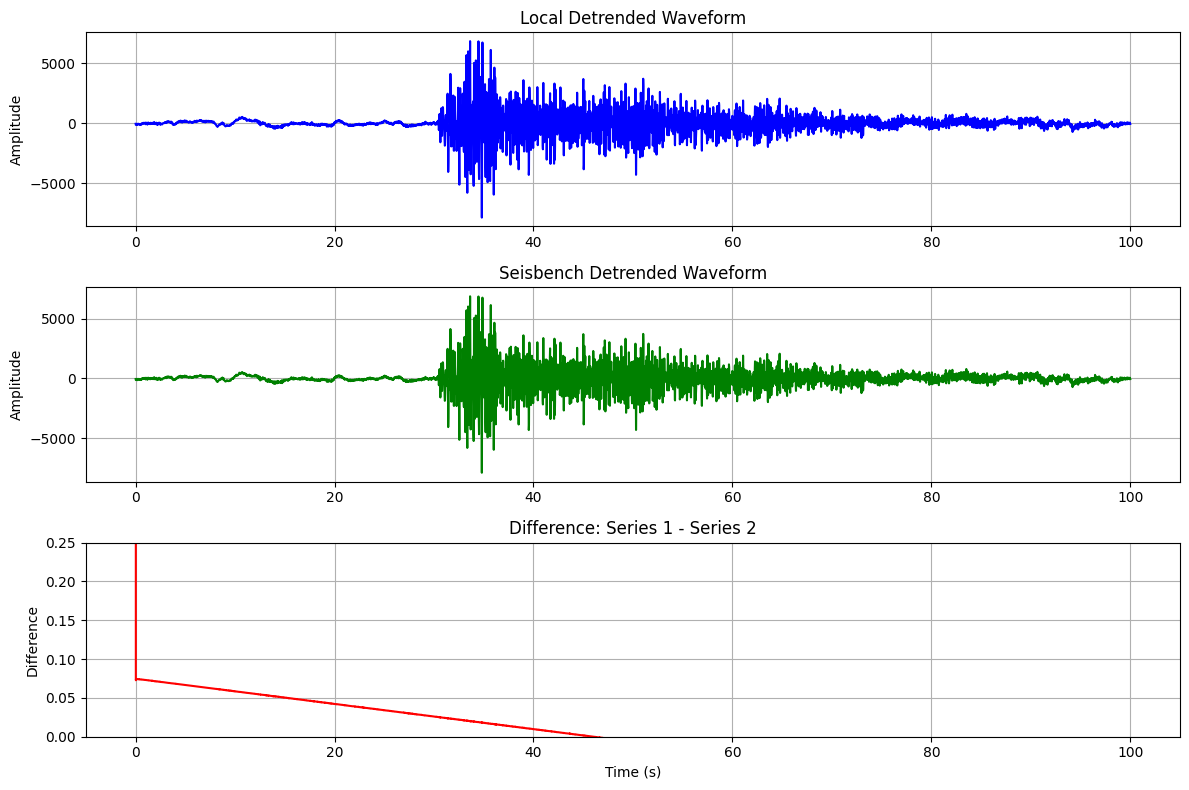

In [8]:
# Example time series
t = np.linspace(0, 100, 5000)  # 10 seconds, 500 samples
series1 = detrended_data_local[2][0:5000]
series2 = detrended_batch[0][2].numpy()

# Difference
diff = series1 - series2

# Plot
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(t, series1, label="Local Detrended Waveforms", color='blue')
plt.ylabel("Amplitude")
plt.title("Local Detrended Waveform")
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(t, series2, label="Seisbench Detrended Waveforms", color='green')
plt.ylabel("Amplitude")
plt.title("Seisbench Detrended Waveform")
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(t, diff, label="Difference", color='red')
plt.xlabel("Time (s)")
plt.ylabel("Difference")
plt.title("Difference: Series 1 - Series 2")
plt.grid(True)
plt.ylim(0,0.25)

plt.tight_layout()
plt.show()


## Comparing tapering

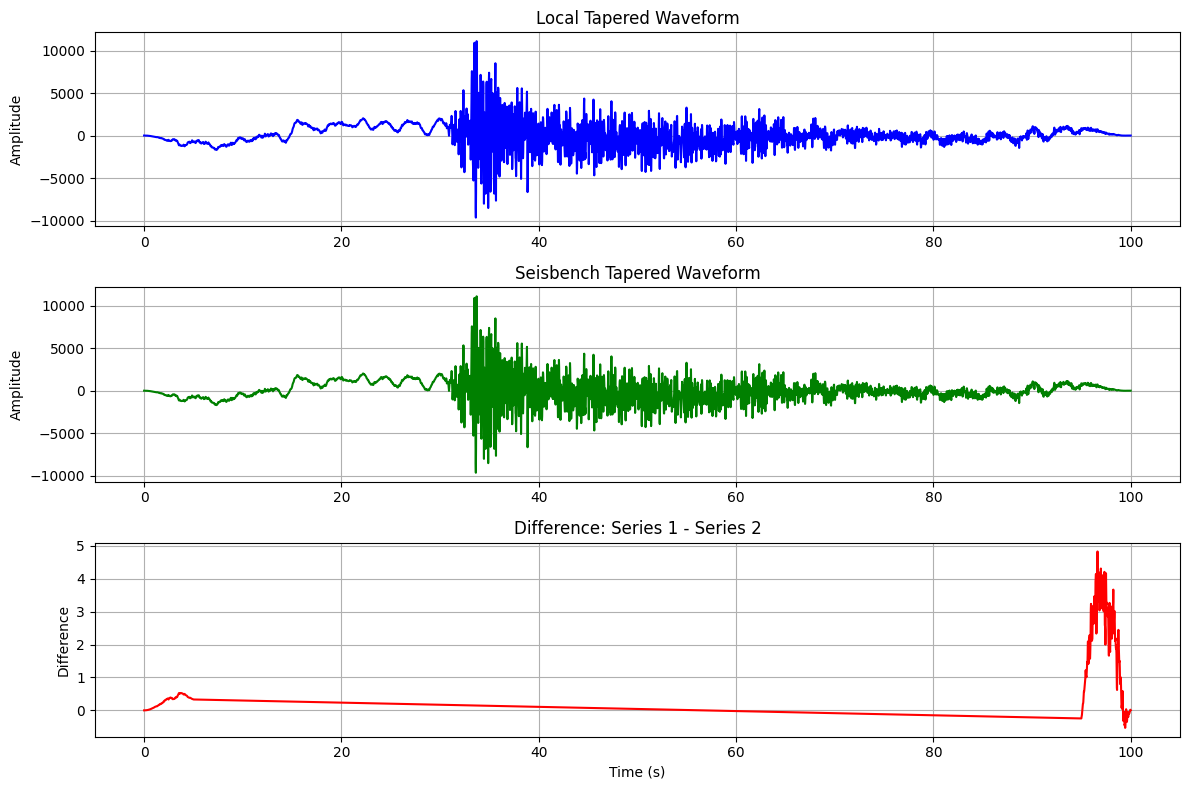

In [9]:
# Example time series
t = np.linspace(0, 100, 5000)  # 10 seconds, 500 samples
series1 = tapered_data[0][:5000]
series2 = tapered_batch[0][0].numpy()

# Difference
diff = series1 - series2

# Plot
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(t, series1, label="Local Tapered Waveforms", color='blue')
plt.ylabel("Amplitude")
plt.title("Local Tapered Waveform")
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(t, series2, label="Seisbench Tapered Waveforms", color='green')
plt.ylabel("Amplitude")
plt.title("Seisbench Tapered Waveform")
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(t, diff, label="Difference", color='red')
plt.xlabel("Time (s)")
plt.ylabel("Difference")
plt.title("Difference: Series 1 - Series 2")
plt.grid(True)

plt.tight_layout()
plt.show()


## Comparing Filtering

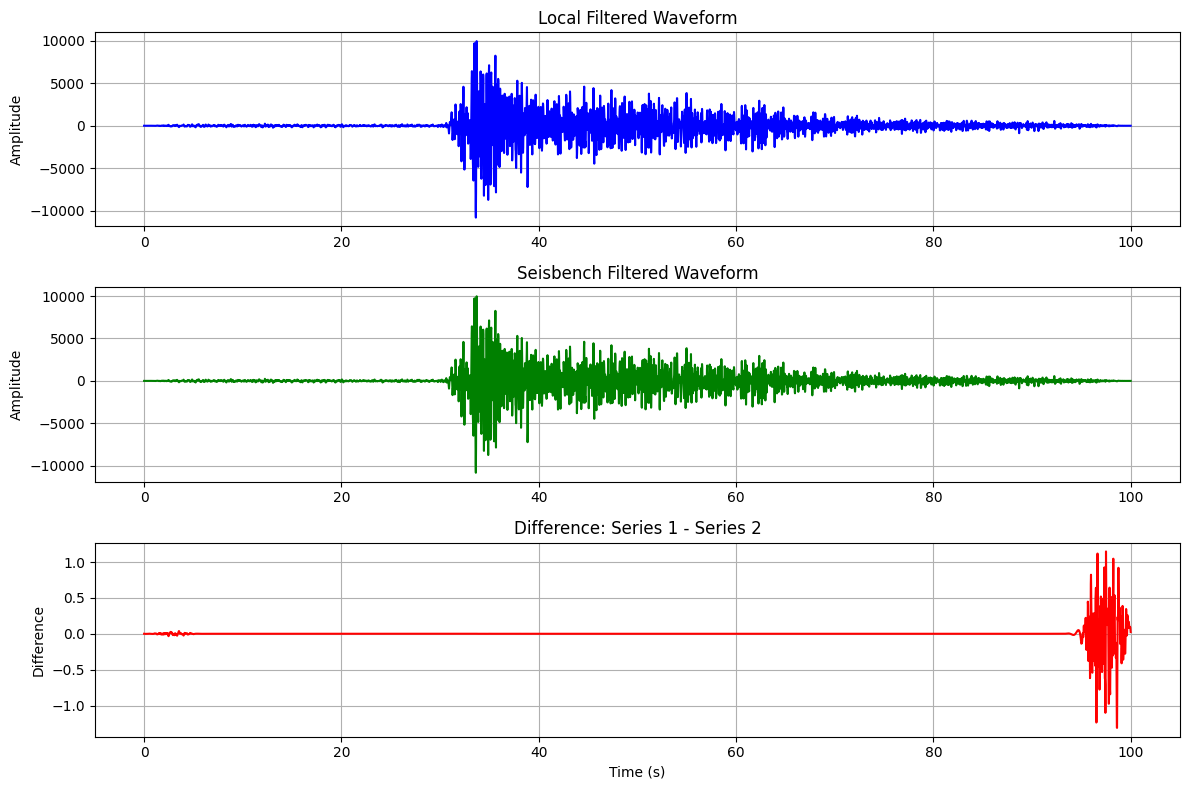

In [10]:
# Example time series
t = np.linspace(0, 100, 5000)  # 10 seconds, 500 samples
series1 = resampled_data[0][0][:5000]
series2 = filtered_batch[0][0].numpy()

# Difference
diff = series1 - series2

# Plot
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(t, series1, label="Local Tapered Waveforms", color='blue')
plt.ylabel("Amplitude")
plt.title("Local Filtered Waveform")
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(t, series2, label="Seisbench Tapered Waveforms", color='green')
plt.ylabel("Amplitude")
plt.title("Seisbench Filtered Waveform")
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(t, diff, label="Difference", color='red')
plt.xlabel("Time (s)")
plt.ylabel("Difference")
plt.title("Difference: Series 1 - Series 2")
plt.grid(True)

plt.tight_layout()
plt.show()


## Comparing normalization

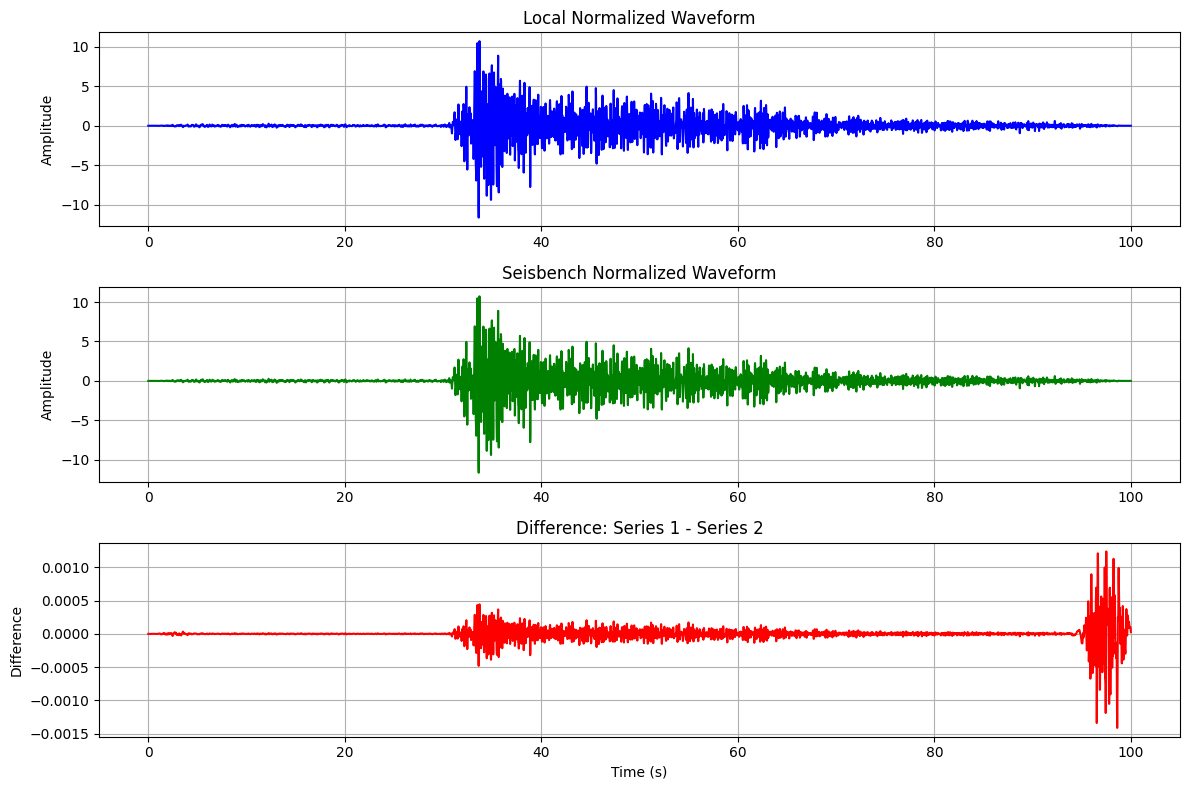

In [11]:
# Example time series
t = np.linspace(0, 100, 5000)  # 10 seconds, 500 samples
series1 = norm[0][0][:5000]
series2 = norm_batch[0][0].numpy()

# Difference
diff = series1 - series2

# Plot
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(t, series1, label="Local Tapered Waveforms", color='blue')
plt.ylabel("Amplitude")
plt.title("Local Normalized Waveform")
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(t, series2, label="Seisbench Tapered Waveforms", color='green')
plt.ylabel("Amplitude")
plt.title("Seisbench Normalized Waveform")
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(t, diff, label="Difference", color='red')
plt.xlabel("Time (s)")
plt.ylabel("Difference")
plt.title("Difference: Series 1 - Series 2")
plt.grid(True)

plt.tight_layout()
plt.show()


## Comparing the spectrograms in both versions

In [12]:
from helper_functions import extract_spectrograms
help(extract_spectrograms)

Help on function extract_spectrograms in module helper_functions:

extract_spectrograms(waveforms=[], fs=50, nperseg=256, overlap=0.5, print_shape=False)



100%|██████████| 1/1 [00:00<00:00, 946.58it/s]


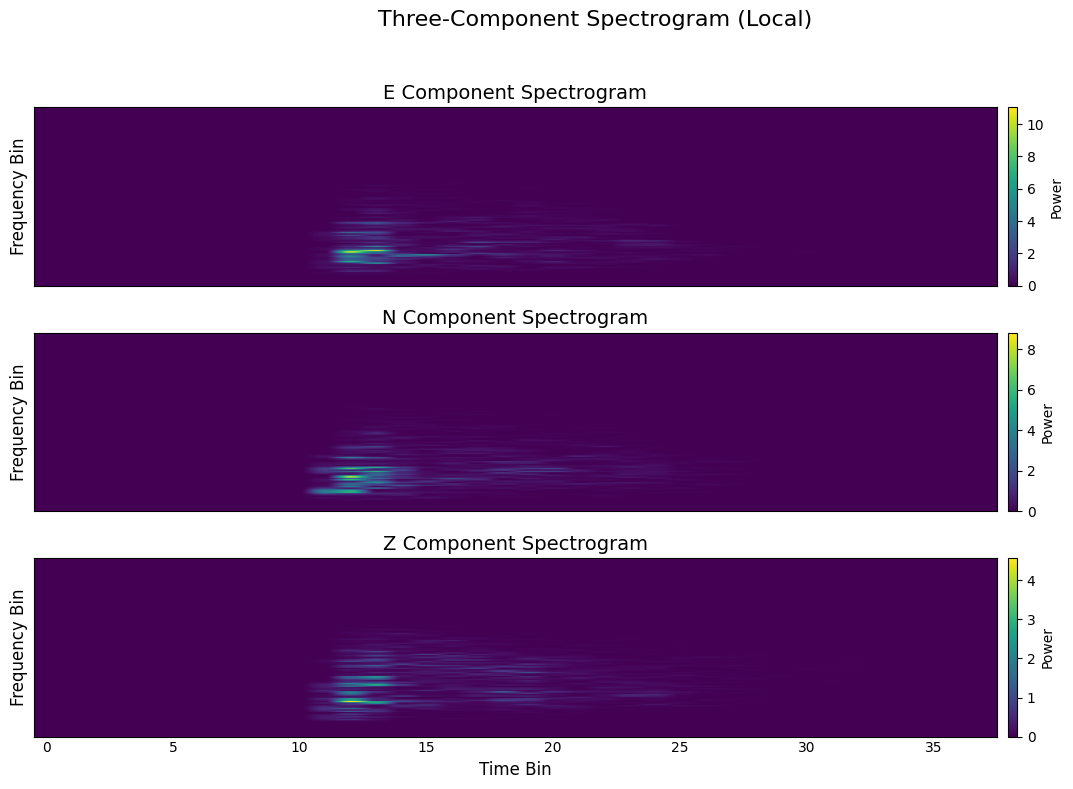

In [13]:
nperseg=256
overlap=0.5
fs = 50
noverlap = int(nperseg * overlap)  # Calculate overlap
f, t, _ = signal.spectrogram(norm, nperseg=nperseg, noverlap=noverlap, fs=fs)

spec_local = extract_spectrograms(norm)


# Assume `spectrogram` has shape (1, 3, 129, 38)
# spectrogram = your_spectrogram_array
# f, t = frequencies and times from signal.spectrogram

components = ['Z', 'N', 'E']
spec = spec_local[0]  # Remove batch dimension, now shape (3, 129, 38)

# Assume `spectrogram` is a torch.Tensor of shape (1, 3, 129, 38)
spec = spec_local[0] # shape: (3, 129, 38)



components = ['E', 'N', 'Z']

plt.figure(figsize=(12, 8))

for i in range(3):
    ax = plt.subplot(3, 1, i + 1)
    im = ax.imshow(
        spec[i],
        aspect='auto',
        origin='lower',
        cmap='viridis'
    )
    ax.set_title(f"{components[i]} Component Spectrogram", fontsize=14)
    ax.set_ylabel("Frequency Bin", fontsize=12)

    # remove grid lines
    ax.grid(False)                 # turn off the grid
    ax.tick_params(axis='both', length=0)  # hide tick marks
    ax.set_yticks([])              # comment out if you still want y-tick labels

    plt.colorbar(im, ax=ax, label='Power', pad=0.01)

    if i == 2:
        ax.set_xlabel("Time Bin", fontsize=12)
    else:
        ax.set_xticks([])

plt.suptitle("Three-Component Spectrogram (Local)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


## Seisbench Spectrogram

In [14]:
def tukey_window_torch(M, alpha=0.25, dtype=torch.float32, device='cpu'):
    if alpha <= 0:
        return torch.ones(M, dtype=dtype, device=device)
    elif alpha >= 1.0:
        return torch.hann_window(M, periodic=False, dtype=dtype, device=device)

    n = torch.arange(M, dtype=dtype, device=device)
    window = torch.ones(M, dtype=dtype, device=device)

    taper_len = int(alpha * (M - 1) / 2)

    # Rising edge
    mask1 = n < taper_len
    window[mask1] = 0.5 * (1 + torch.cos(
        torch.pi * (2 * n[mask1] / (alpha * (M - 1)) - 1)
    ))

    # Falling edge
    mask2 = n > (M - 1 - taper_len)
    window[mask2] = 0.5 * (1 + torch.cos(
        torch.pi * (2 * n[mask2] / (alpha * (M - 1)) - 2 / alpha + 1)
    ))

    return window




def spectrogram_torch_like_scipy(x, fs, nperseg=256, overlap=0.5):
    """
    Bit-for-bit replica of scipy.signal.spectrogram with all defaults:
        window='hann'  (periodic, not symmetric!)
        detrend='constant'   <-- mean removed after window
        scaling='density', mode='psd'
        boundary=None
    
    Parameters
    ----------
    x  : Tensor (B, C, N)      batch × channels × samples
    fs : float                 sampling rate [Hz]
    
    Returns
    -------
    psd   : Tensor (B, C, F, T)   PSD [unit² / Hz]
    freqs : 1-D Tensor length F
    times : 1-D Tensor length T
    """
    B, C, N = x.shape
    
    # Match SciPy's overlap calculation exactly
    noverlap = int(nperseg * overlap)
    hop = nperseg - noverlap
    
    # 1 ▸ periodic Hann (SciPy default is periodic=True)
    #win = torch.hann_window(nperseg, periodic=True,
    #                        dtype=x.dtype, device=x.device)
    
    win = tukey_window_torch(nperseg, alpha=0.25, dtype=x.dtype, device=x.device)

    # 2 ▸ frame the signal  → (B, C, T, L)
    segs = x.unfold(-1, nperseg, hop)
    
    # 3 ▸ detrend='constant' after windowing (subtract mean of each segment)
    segs = segs - segs.mean(dim=-1, keepdim=True)
    
    # 3 ▸ apply window after detrending
    segs = segs * win
    

    
    # 5 ▸ rFFT, then put freq before time  → (B, C, F, T)
    Z = torch.fft.rfft(segs, n=nperseg, dim=-1).permute(0, 1, 3, 2)
    
    # 6 ▸ PSD  |Z|² / (fs Σ w²)
    W = win.pow(2).sum()
    psd = (Z.abs() ** 2) / (W * fs)
    
    # 7 ▸ one-sided ×2 (skip DC & Nyquist)
    if nperseg % 2 == 0:
        psd[..., 1:-1, :] *= 2.0
    else:
        psd[..., 1:, :] *= 2.0
    
    # Generate frequency and time arrays to match SciPy exactly
    freqs = torch.fft.rfftfreq(nperseg, 1 / fs).to(x.device)
    
    # SciPy centers time stamps on window centers using integer division
    # Time of center of first window is nperseg//2 samples
    # Each subsequent window is shifted by hop samples
    times = (torch.arange(psd.shape[-1], dtype=x.dtype, device=x.device) * hop + nperseg // 2) / fs
    
    return psd, freqs, times

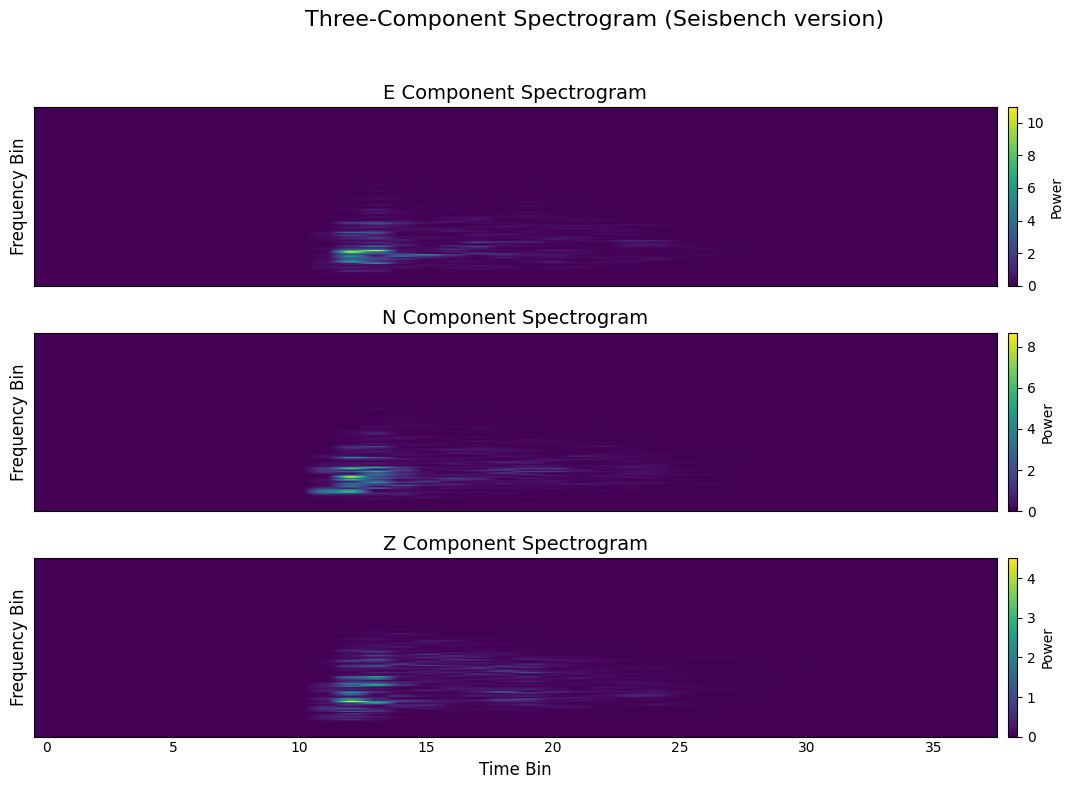

In [15]:
# Convert the processed waveforms to spectrograms
spec_torch = spectrogram_torch_like_scipy(norm_batch, fs = 50)

spectrogram = spec_torch[0][0].cpu().numpy()




components = ['E', 'N', 'Z']

plt.figure(figsize=(12, 8))

for i in range(3):
    ax = plt.subplot(3, 1, i + 1)
    im = ax.imshow(
        spectrogram[i],
        aspect='auto',
        #interpolation = 'nearest',
        origin='lower',
        cmap='viridis'
    )
    ax.set_title(f"{components[i]} Component Spectrogram", fontsize=14)
    ax.set_ylabel("Frequency Bin", fontsize=12)

    # remove grid lines
    ax.grid(False)                 # turn off the grid
    ax.tick_params(axis='both', length=0)  # hide tick marks
    ax.set_yticks([])              # comment out if you still want y-tick labels

    plt.colorbar(im, ax=ax, label='Power', pad=0.01)

    if i == 2:
        ax.set_xlabel("Time Bin", fontsize=12)
    else:
        ax.set_xticks([])

plt.suptitle("Three-Component Spectrogram (Seisbench version)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

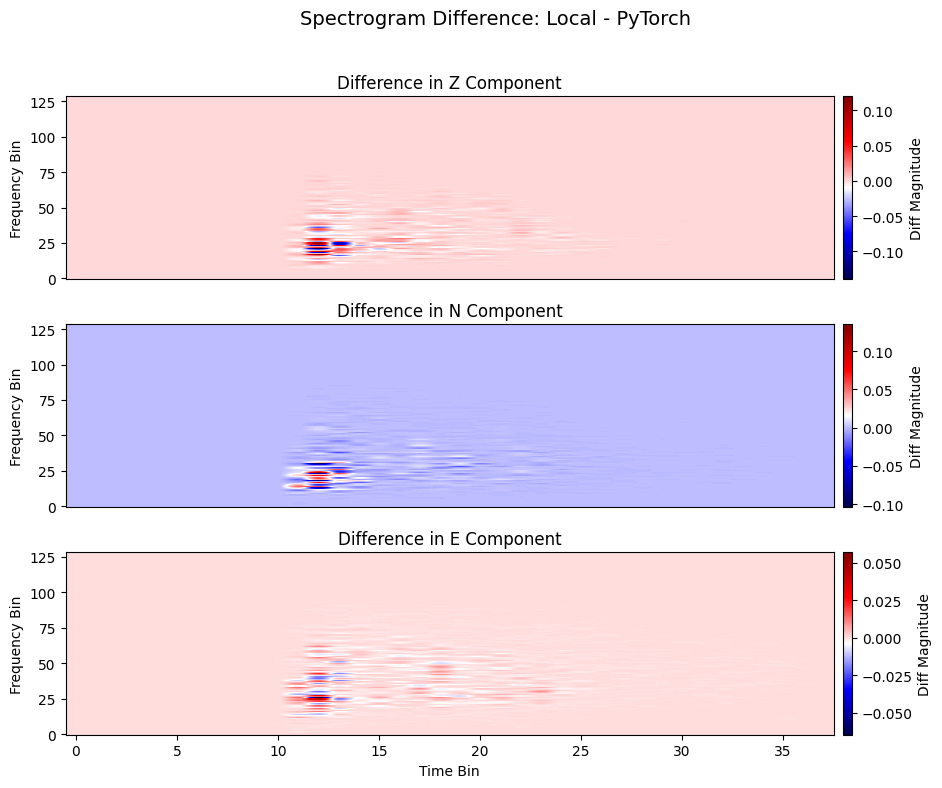

In [16]:
# Assume these are torch.Tensors, convert to numpy arrays
diff = (spec_local - spec_torch[0].cpu().numpy())[0] # shape: (3, 129, 38)

components = ['Z', 'N', 'E']

plt.figure(figsize=(10, 8))
for i in range(3):
    plt.subplot(3, 1, i + 1)
    plt.imshow(diff[i], aspect='auto', origin='lower', cmap='seismic')
    plt.title(f"Difference in {components[i]} Component")
    plt.ylabel("Frequency Bin")
    if i == 2:
        plt.xlabel("Time Bin")
    else:
        plt.xticks([])
    plt.colorbar(label='Diff Magnitude', pad=0.01)

plt.suptitle("Spectrogram Difference: Local - PyTorch", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


## Testing with sinusoidal version

SPECTROGRAM MATCHING TEST SUITE

Test Configuration 1:
  fs=1000, nperseg=256, overlap=0.5, duration=2.0s

  Testing with sine_wave:
✓ PASS: Frequency arrays
      Max diff: 0.00e+00
✓ PASS: Time arrays
      Max diff: 5.53e-08
✗ FAIL: Spectrograms
      Max rel error: 3.46e+04, Max abs diff: 2.44e-04
✓ PASS: Shapes
✗ FAIL: Value ranges
      SciPy: [3.62e-15, 8.26e-02], PyTorch: [6.57e-13, 8.25e-02]

  Testing with multi_tone:
✓ PASS: Frequency arrays
      Max diff: 0.00e+00
✓ PASS: Time arrays
      Max diff: 5.53e-08
✗ FAIL: Spectrograms
      Max rel error: 1.85e+03, Max abs diff: 3.59e-04
✓ PASS: Shapes
✗ FAIL: Value ranges
      SciPy: [3.46e-14, 1.05e-01], PyTorch: [1.57e-13, 1.05e-01]

  Testing with chirp:
✓ PASS: Frequency arrays
      Max diff: 0.00e+00
✓ PASS: Time arrays
      Max diff: 5.53e-08
✗ FAIL: Spectrograms
      Max rel error: 1.99e+03, Max abs diff: 2.04e-04
✓ PASS: Shapes
✗ FAIL: Value ranges
      SciPy: [4.36e-15, 2.17e-02], PyTorch: [1.16e-14, 2.19e-02]

  

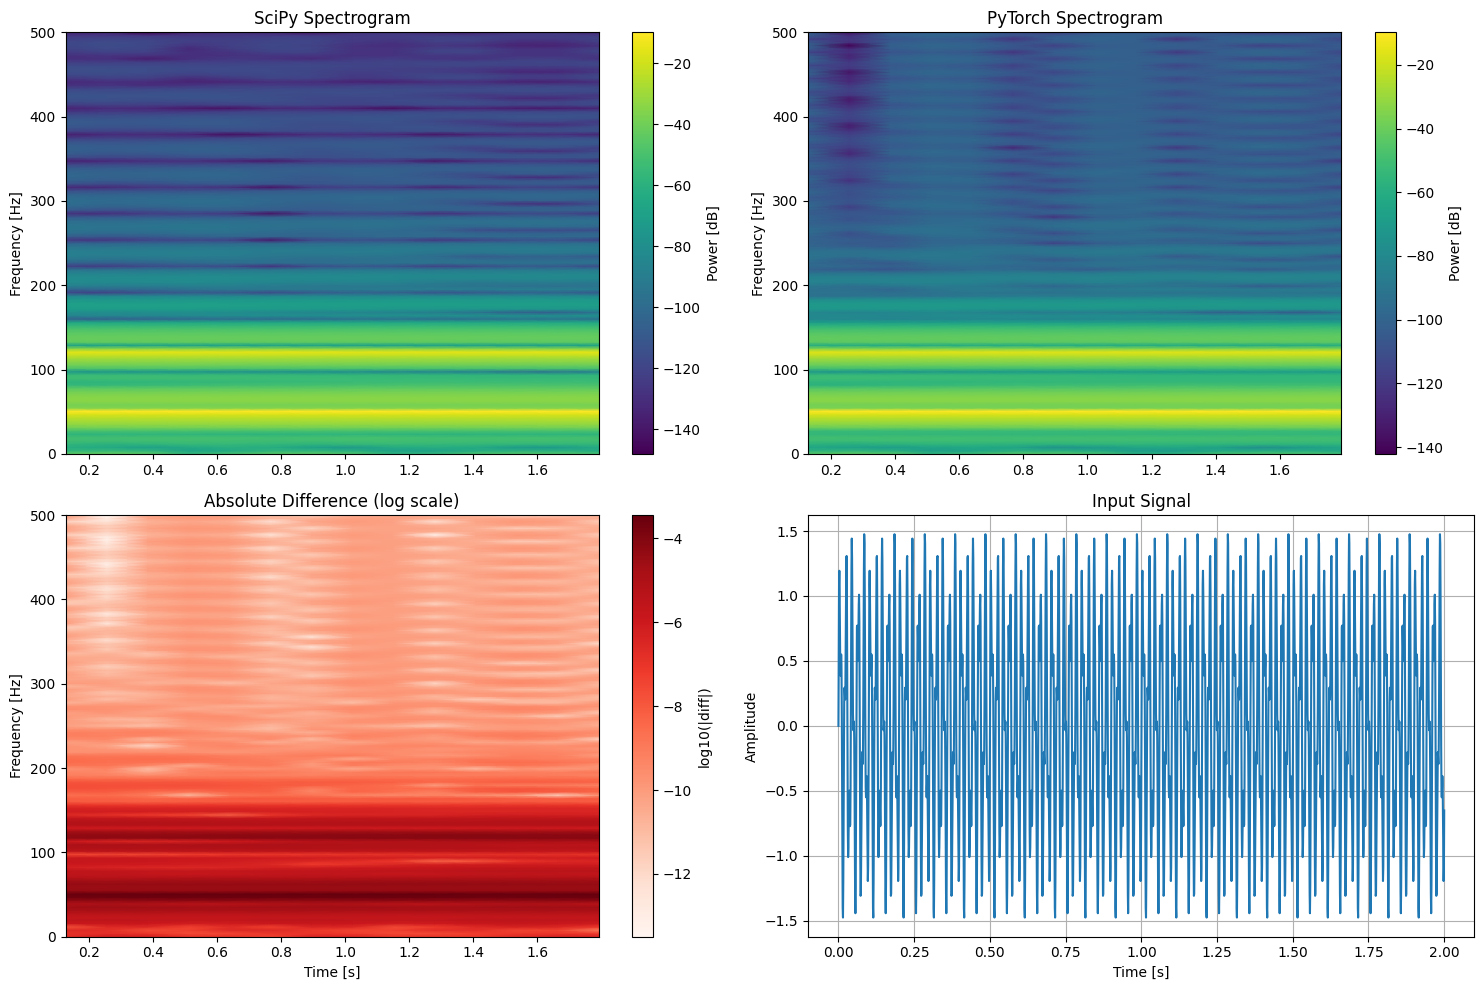

SPECTROGRAM MATCHING TEST SUITE

Test Configuration 1:
  fs=1000, nperseg=256, overlap=0.5, duration=2.0s

  Testing with sine_wave:
✓ PASS: Frequency arrays
      Max diff: 0.00e+00
✓ PASS: Time arrays
      Max diff: 5.53e-08
✗ FAIL: Spectrograms
      Max rel error: 3.46e+04, Max abs diff: 2.44e-04
✓ PASS: Shapes
✗ FAIL: Value ranges
      SciPy: [3.62e-15, 8.26e-02], PyTorch: [6.57e-13, 8.25e-02]

  Testing with multi_tone:
✓ PASS: Frequency arrays
      Max diff: 0.00e+00
✓ PASS: Time arrays
      Max diff: 5.53e-08
✗ FAIL: Spectrograms
      Max rel error: 1.85e+03, Max abs diff: 3.59e-04
✓ PASS: Shapes
✗ FAIL: Value ranges
      SciPy: [3.46e-14, 1.05e-01], PyTorch: [1.57e-13, 1.05e-01]

  Testing with chirp:
✓ PASS: Frequency arrays
      Max diff: 0.00e+00
✓ PASS: Time arrays
      Max diff: 5.53e-08
✗ FAIL: Spectrograms
      Max rel error: 1.99e+03, Max abs diff: 2.04e-04
✓ PASS: Shapes
✗ FAIL: Value ranges
      SciPy: [4.36e-15, 2.17e-02], PyTorch: [1.16e-14, 2.19e-02]

  

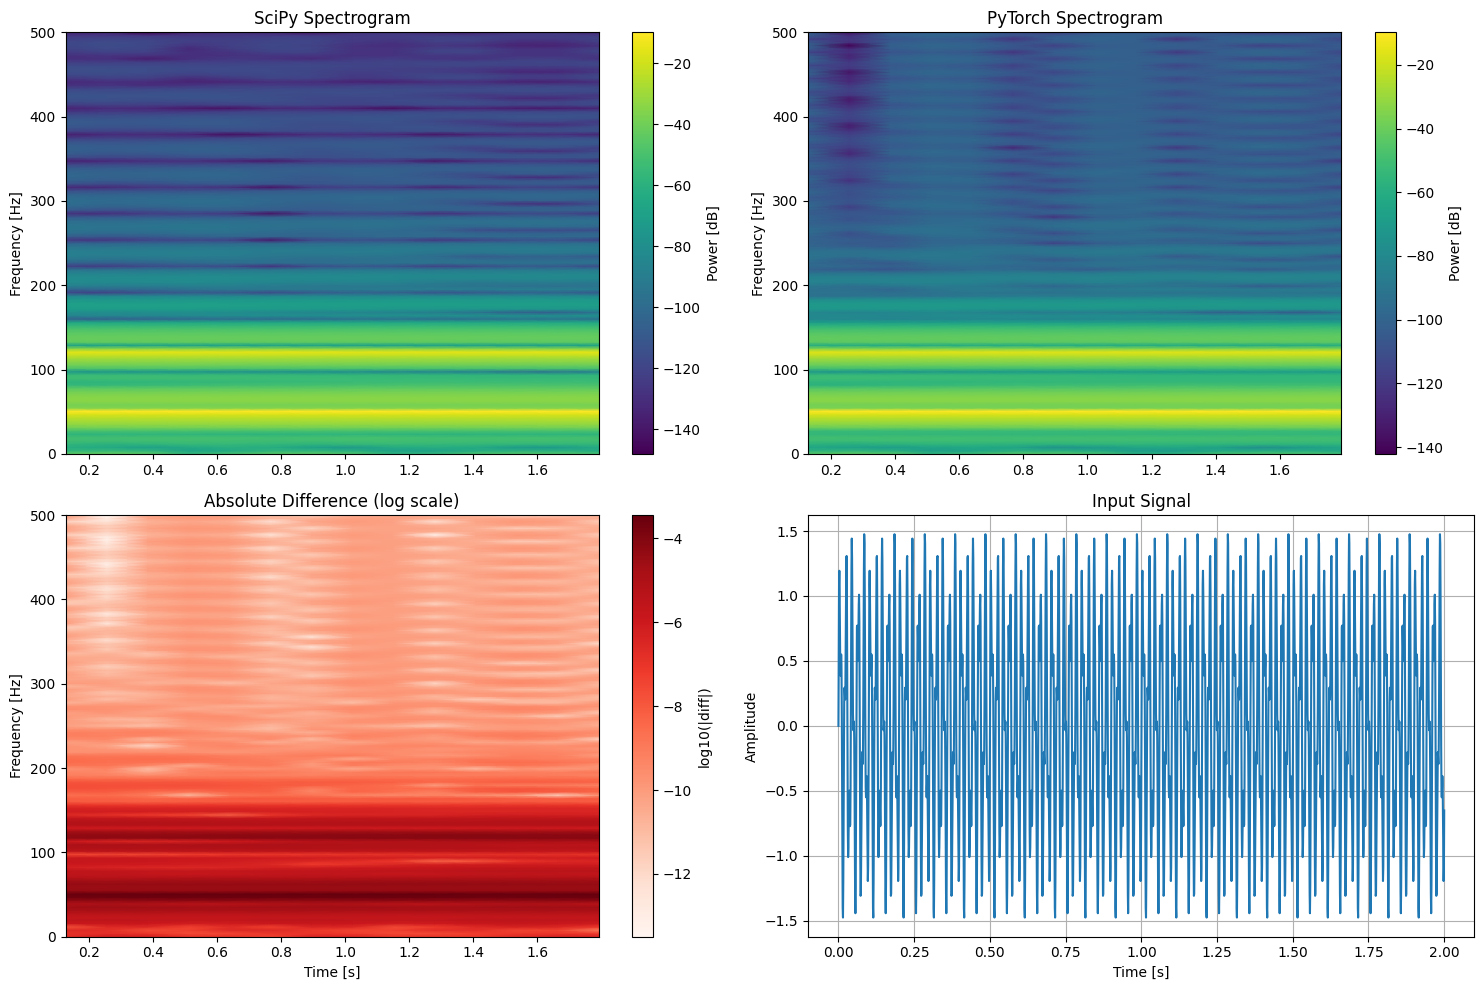

In [17]:
import torch
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

def test_spectrograms_match(rtol=1e-5, atol=1e-8, verbose=True):
    """
    Comprehensive test suite to verify PyTorch and SciPy spectrograms match exactly.
    
    Parameters:
    -----------
    rtol : float
        Relative tolerance for np.allclose
    atol : float
        Absolute tolerance for np.allclose
    verbose : bool
        Whether to print detailed output
    
    Returns:
    --------
    bool : True if all tests pass
    """
    
    def print_test_result(test_name, passed, details=""):
        status = "✓ PASS" if passed else "✗ FAIL"
        print(f"{status}: {test_name}")
        if details and (verbose or not passed):
            print(f"      {details}")
    
    all_tests_passed = True
    
    print("=" * 60)
    print("SPECTROGRAM MATCHING TEST SUITE")
    print("=" * 60)
    
    # Test configurations
    test_configs = [
        {"fs": 1000, "nperseg": 256, "overlap": 0.5, "duration": 2.0},
        {"fs": 8000, "nperseg": 512, "overlap": 0.75, "duration": 1.0},
        {"fs": 44100, "nperseg": 1024, "overlap": 0.25, "duration": 0.5},
        {"fs": 16000, "nperseg": 128, "overlap": 0.0, "duration": 1.5},  # No overlap
    ]
    
    # Test signals
    def create_test_signals(fs, duration):
        t = np.linspace(0, duration, int(fs * duration), endpoint=False)
        signals = {
            "sine_wave": np.sin(2 * np.pi * 440 * t),
            "multi_tone": (np.sin(2 * np.pi * 50 * t) + 
                          0.5 * np.sin(2 * np.pi * 120 * t) + 
                          0.25 * np.sin(2 * np.pi * 300 * t)),
            "chirp": signal.chirp(t, f0=100, f1=1000, t1=duration),
            "noise": np.random.randn(len(t)),
            "impulse": np.zeros(len(t))
        }
        # Add impulse at 1/4 of the signal
        signals["impulse"][len(t)//4] = 1.0
        return signals, t
    
    for config_idx, config in enumerate(test_configs):
        fs = config["fs"]
        nperseg = config["nperseg"]
        overlap = config["overlap"]
        duration = config["duration"]
        noverlap = int(nperseg * overlap)
        
        print(f"\nTest Configuration {config_idx + 1}:")
        print(f"  fs={fs}, nperseg={nperseg}, overlap={overlap}, duration={duration}s")
        
        test_signals, t = create_test_signals(fs, duration)
        
        for signal_name, test_signal in test_signals.items():
            print(f"\n  Testing with {signal_name}:")
            
            try:
                # SciPy computation
                f_scipy, t_scipy, Sxx_scipy = signal.spectrogram(
                    test_signal, fs=fs, nperseg=nperseg, noverlap=noverlap
                )
                
                # PyTorch computation
                x_torch = torch.tensor(test_signal).unsqueeze(0).unsqueeze(0).float()
                psd_torch, freqs_torch, times_torch = spectrogram_torch_like_scipy(
                    x_torch, fs, nperseg=nperseg, overlap=overlap
                )
                
                # Extract single channel for comparison
                psd_torch_np = psd_torch[0, 0].numpy()
                freqs_torch_np = freqs_torch.numpy()
                times_torch_np = times_torch.numpy()
                
                # Test 1: Frequency arrays
                freq_match = np.allclose(f_scipy, freqs_torch_np, rtol=rtol, atol=atol)
                print_test_result(
                    "Frequency arrays", freq_match,
                    f"Max diff: {np.max(np.abs(f_scipy - freqs_torch_np)):.2e}"
                )
                
                # Test 2: Time arrays
                time_match = np.allclose(t_scipy, times_torch_np, rtol=rtol, atol=atol)
                print_test_result(
                    "Time arrays", time_match,
                    f"Max diff: {np.max(np.abs(t_scipy - times_torch_np)):.2e}"
                )
                
                # Test 3: Spectrograms
                spec_match = np.allclose(Sxx_scipy, psd_torch_np, rtol=rtol, atol=atol)
                max_rel_error = np.max(np.abs((Sxx_scipy - psd_torch_np) / (Sxx_scipy + 1e-20)))
                print_test_result(
                    "Spectrograms", spec_match,
                    f"Max rel error: {max_rel_error:.2e}, Max abs diff: {np.max(np.abs(Sxx_scipy - psd_torch_np)):.2e}"
                )
                
                # Test 4: Shapes
                shape_match = (Sxx_scipy.shape == psd_torch_np.shape and 
                              f_scipy.shape == freqs_torch_np.shape and 
                              t_scipy.shape == times_torch_np.shape)
                print_test_result("Shapes", shape_match)
                
                # Test 5: Value ranges (sanity check)
                scipy_range = (Sxx_scipy.min(), Sxx_scipy.max())
                torch_range = (psd_torch_np.min(), psd_torch_np.max())
                range_reasonable = (abs(scipy_range[0] - torch_range[0]) / (abs(scipy_range[0]) + 1e-20) < 0.1 and
                                  abs(scipy_range[1] - torch_range[1]) / (abs(scipy_range[1]) + 1e-20) < 0.1)
                print_test_result(
                    "Value ranges", range_reasonable,
                    f"SciPy: [{scipy_range[0]:.2e}, {scipy_range[1]:.2e}], PyTorch: [{torch_range[0]:.2e}, {torch_range[1]:.2e}]"
                )
                
                # Update overall test status
                config_passed = freq_match and time_match and spec_match and shape_match and range_reasonable
                all_tests_passed = all_tests_passed and config_passed
                
            except Exception as e:
                print_test_result(f"Exception occurred", False, str(e))
                all_tests_passed = False
    
    print("\n" + "=" * 60)
    if all_tests_passed:
        print("🎉 ALL TESTS PASSED! SciPy and PyTorch spectrograms match exactly.")
    else:
        print("❌ SOME TESTS FAILED! Check the output above for details.")
    print("=" * 60)
    
    return all_tests_passed


def plot_comparison(test_signal, fs, nperseg=256, overlap=0.5, figsize=(15, 10)):
    """
    Create a visual comparison plot of SciPy vs PyTorch spectrograms.
    """
    noverlap = int(nperseg * overlap)
    
    # Compute spectrograms
    f_scipy, t_scipy, Sxx_scipy = signal.spectrogram(
        test_signal, fs=fs, nperseg=nperseg, noverlap=noverlap
    )
    
    x_torch = torch.tensor(test_signal).unsqueeze(0).unsqueeze(0).float()
    psd_torch, freqs_torch, times_torch = spectrogram_torch_like_scipy(
        x_torch, fs, nperseg=nperseg, overlap=overlap
    )
    psd_torch_np = psd_torch[0, 0].numpy()
    
    # Create comparison plot
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    
    # SciPy spectrogram
    im1 = axes[0, 0].pcolormesh(t_scipy, f_scipy, 10 * np.log10(Sxx_scipy + 1e-20), 
                                shading='gouraud', cmap='viridis')
    axes[0, 0].set_title('SciPy Spectrogram')
    axes[0, 0].set_ylabel('Frequency [Hz]')
    plt.colorbar(im1, ax=axes[0, 0], label='Power [dB]')
    
    # PyTorch spectrogram
    im2 = axes[0, 1].pcolormesh(times_torch.numpy(), freqs_torch.numpy(), 
                                10 * np.log10(psd_torch_np + 1e-20), 
                                shading='gouraud', cmap='viridis')
    axes[0, 1].set_title('PyTorch Spectrogram')
    axes[0, 1].set_ylabel('Frequency [Hz]')
    plt.colorbar(im2, ax=axes[0, 1], label='Power [dB]')
    
    # Difference plot
    diff = np.abs(Sxx_scipy - psd_torch_np)
    im3 = axes[1, 0].pcolormesh(t_scipy, f_scipy, np.log10(diff + 1e-20), 
                                shading='gouraud', cmap='Reds')
    axes[1, 0].set_title('Absolute Difference (log scale)')
    axes[1, 0].set_xlabel('Time [s]')
    axes[1, 0].set_ylabel('Frequency [Hz]')
    plt.colorbar(im3, ax=axes[1, 0], label='log10(|diff|)')
    
    # Time series
    t_signal = np.linspace(0, len(test_signal)/fs, len(test_signal))
    axes[1, 1].plot(t_signal, test_signal)
    axes[1, 1].set_title('Input Signal')
    axes[1, 1].set_xlabel('Time [s]')
    axes[1, 1].set_ylabel('Amplitude')
    axes[1, 1].grid(True)
    
    plt.tight_layout()
    return fig


if __name__ == "__main__":
    # Run the comprehensive test
    test_passed = test_spectrograms_match(verbose=True)
    
    # Create a visual comparison for a sample signal
    print("\nCreating visual comparison...")
    fs = 1000
    duration = 2.0
    t = np.linspace(0, duration, int(fs * duration), endpoint=False)
    test_signal = np.sin(2 * np.pi * 50 * t) + 0.5 * np.sin(2 * np.pi * 120 * t)
    
    fig = plot_comparison(test_signal, fs)
    plt.show()
    
    
    

# Run all tests
test_passed = test_spectrograms_match(verbose=True)

# Create visual comparison
fs = 1000
duration = 2.0
t = np.linspace(0, duration, int(fs * duration), endpoint=False)
test_signal = np.sin(2 * np.pi * 50 * t) + 0.5 * np.sin(2 * np.pi * 120 * t)
fig = plot_comparison(test_signal, fs)
plt.show()




## Old seisbench version

In [18]:
def extract_spectrograms_pytorch(waveforms, fs, nperseg=256, overlap=0.5):
    """
    Extract spectrograms, time segments, and frequency bins from waveforms.

    Parameters:
        waveforms: Tensor of shape (n_waveforms, n_channels, n_samples)
        fs: Sampling rate (Hz)
        nperseg: Number of FFT points
        overlap: Fractional overlap between segments

    Returns:
        spectrograms: Tensor of shape (n_waveforms, n_channels, frequencies, time_segments)
        frequencies: Array of frequency bins (Hz)
        time_segments: Array of time segment centers (seconds)
    """
    noverlap = int(nperseg * overlap)  # Calculate overlap
    hop_length = nperseg - noverlap  # Calculate hop length

    # Compute frequencies
    frequencies = torch.fft.rfftfreq(nperseg, d=1/fs)

    # Compute time segments
    time_segments = torch.arange(0, waveforms.shape[-1] - nperseg + 1, hop_length) / fs
    
    window = torch.hann_window(nperseg, device=waveforms.device)


    # Example spectrogram to get dimensions
    example_spectrogram = torch.stft(
        waveforms[0, 0], n_fft=nperseg, window = window, hop_length=hop_length, win_length=nperseg, 
        return_complex=True, center=False, normalized = False
    )
    freq_bins, time_bins = example_spectrogram.shape[-2], example_spectrogram.shape[-1]

    # Initialize tensor for spectrograms
    spectrograms = torch.zeros(
        (waveforms.shape[0], waveforms.shape[1], freq_bins, time_bins), dtype=torch.complex64
    )

    # Compute spectrograms
    for i in range(waveforms.shape[0]):  # For each waveform
        for j in range(waveforms.shape[1]):  # For each channel
            Sxx = torch.stft(
                waveforms[i, j], n_fft=nperseg, hop_length=hop_length, win_length=nperseg, window = window,  
                return_complex=True, center=False, normalized= False,
            )
            spectrograms[i, j] = Sxx  # Fill the tensor

    # Convert complex spectrogram to magnitude
    spectrograms = torch.abs(spectrograms)**(2)

    return spectrograms, frequencies, time_segments


# Inference config
device = 'cuda'
model = model_quakexnet_2d
model.to(device)
model.eval()

# Storage
seisbench_probs = []
seisbench_event_ids = []
seisbench_source_labels = []

# Constants
pre_event_duration = 10
post_event_duration = 90
sample_rate = 50
num_samples = 5000
n_channels = 3
window_alpha = 0.1
lowcut = 1   # define these
highcut = 20
fs = 50

for _, event in tqdm(combined_df.iterrows(), total=len(combined_df), desc="Processing events"):

    try:
        # Metadata
        network = event["station_network_code"]
        station = event["station_code"]
        channel = event["station_channel_code"]
        location = event["station_location_code"]
        event_id = event["event_id"]
        starttime = obspy.UTCDateTime(event["trace_start_time"])
        seisbench_source_labels.append(event['source_type'])

        # Download waveform
        stream = client.get_waveforms(
            network=network,
            station=station,
            location=location,
            channel=f"{channel}?",
            starttime=starttime - pre_event_duration,
            endtime=starttime + post_event_duration
        )

        # Resample to 50 Hz
        stream.resample(sample_rate)

        # Extract data and reshape
        data = np.array(stream)[:, :num_samples].reshape(1, n_channels, num_samples)
        batch = torch.tensor(data, dtype=torch.float32)

        # Preprocessing
        batch = linear_detrend(batch)

        # Apply Tukey taper
        taper = torch.tensor(scipy.signal.windows.tukey(num_samples, alpha=window_alpha), device=batch.device)
        batch *= taper  # broadcast taper over traces

        # Bandpass filter
        batch = bandpass_filter(batch, fs=fs, lowcut=lowcut, highcut=highcut)

        # Normalize
        

        # Normalize each component by the standard deviation of their absolute values
        batch_abs = torch.abs(batch)
        std_abs = batch_abs.std(dim=-1, keepdim=True)
        norm_batch = batch / (std_abs + 1e-10)  # Avoid division by zero

        
        #batch = normalize_per_trace_globally(batch)

        # Extract spectrogram
        spec = extract_spectrograms_pytorch(batch, fs=sample_rate)
        

        # Run model
        inputs = torch.tensor(spec[0], dtype=torch.float32).to(device)
        with torch.no_grad():
            outputs = model(inputs)
            probs = torch.nn.functional.softmax(outputs, dim=1)

        # Store results
        seisbench_probs.append(probs.cpu())
        seisbench_event_ids.append(event_id)

    except Exception as e:
        print(f"Failed to process event {event.get('event_id', 'unknown')}: {e}")
        continue


Processing events:   0%|          | 0/800 [00:00<?, ?it/s]/tmp/ipykernel_165984/1322525004.py:132: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(spec[0], dtype=torch.float32).to(device)
Processing events:  79%|███████▉  | 633/800 [05:46<01:22,  2.03it/s]

Failed to process event uw10582798: cannot reshape array of size 5000 into shape (1,3,5000)


Processing events:  90%|█████████ | 720/800 [06:30<00:38,  2.08it/s]/tmp/ipykernel_165984/1322525004.py:103: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.array(stream)[:, :num_samples].reshape(1, n_channels, num_samples)
Processing events:  90%|█████████ | 721/800 [06:30<00:36,  2.18it/s]

Failed to process event uw10716693: too many indices for array: array is 1-dimensional, but 2 were indexed


Processing events:  91%|█████████ | 726/800 [06:32<00:34,  2.12it/s]

Failed to process event uw10716693: too many indices for array: array is 1-dimensional, but 2 were indexed


Processing events:  91%|█████████ | 729/800 [06:34<00:33,  2.11it/s]

Failed to process event uw10713718: too many indices for array: array is 1-dimensional, but 2 were indexed


Processing events:  92%|█████████▎| 740/800 [06:39<00:26,  2.29it/s]

Failed to process event uw10727828: too many indices for array: array is 1-dimensional, but 2 were indexed


Processing events:  93%|█████████▎| 741/800 [06:39<00:25,  2.33it/s]

Failed to process event uw10727828: too many indices for array: array is 1-dimensional, but 2 were indexed


Processing events:  93%|█████████▎| 742/800 [06:40<00:26,  2.19it/s]

Failed to process event uw10727828: too many indices for array: array is 1-dimensional, but 2 were indexed


Processing events:  94%|█████████▍| 750/800 [06:44<00:29,  1.71it/s]

Failed to process event uw10731883: too many indices for array: array is 1-dimensional, but 2 were indexed


Processing events:  96%|█████████▋| 772/800 [07:10<00:13,  2.03it/s]

Failed to process event uw10723368: too many indices for array: array is 1-dimensional, but 2 were indexed


Processing events:  97%|█████████▋| 773/800 [07:10<00:12,  2.08it/s]

Failed to process event uw10723368: too many indices for array: array is 1-dimensional, but 2 were indexed


Processing events:  98%|█████████▊| 786/800 [07:17<00:07,  1.96it/s]

Failed to process event uw10710408: too many indices for array: array is 1-dimensional, but 2 were indexed


Processing events: 100%|██████████| 800/800 [07:24<00:00,  1.80it/s]


## New seisbench version

In [19]:
# Inference config
device = 'cuda'
model = model_quakexnet_2d
model.to(device)
model.eval()

# Storage
seisbench_probs_new = []
seisbench_event_ids_new = []
seisbench_source_labels_new = []

# Constants
pre_event_duration = 10
post_event_duration = 90
sample_rate = 50
num_samples = 5000
n_channels = 3
window_alpha = 0.1
lowcut = 1   # define these
highcut = 20
fs = 50

for _, event in tqdm(combined_df.iterrows(), total=len(combined_df), desc="Processing events"):

    try:
        # Metadata
        network = event["station_network_code"]
        station = event["station_code"]
        channel = event["station_channel_code"]
        location = event["station_location_code"]
        event_id = event["event_id"]
        seisbench_source_labels.append(event['source_type'])
        starttime = obspy.UTCDateTime(event["trace_start_time"])

        # Download waveform
        stream = client.get_waveforms(
            network=network,
            station=station,
            location=location,
            channel=f"{channel}?",
            starttime=starttime - pre_event_duration,
            endtime=starttime + post_event_duration
        )

        # Resample to 50 Hz
        stream.resample(sample_rate)

        # Extract data and reshape
        data = np.array(stream)[:, :num_samples].reshape(1, n_channels, num_samples)
        batch = torch.tensor(data, dtype=torch.float32)

        # Preprocessing
        batch = linear_detrend(batch)

        # Apply Tukey taper
        taper = torch.tensor(scipy.signal.windows.tukey(num_samples, alpha=window_alpha), device=batch.device)
        batch *= taper  # broadcast taper over traces

        # Bandpass filter
        batch = bandpass_filter(batch, fs=fs, lowcut=lowcut, highcut=highcut)

        # Normalize
        batch = normalize_per_trace_globally(batch)

        # Extract spectrogram
        spec = spectrogram_torch_like_scipy(batch, fs=sample_rate)

        # Run model
        inputs = torch.tensor(spec[0], dtype=torch.float32).to(device)
        with torch.no_grad():
            outputs = model(inputs)
            probs = torch.nn.functional.softmax(outputs, dim=1)

        # Store results
        seisbench_probs_new.append(probs.cpu())
        seisbench_event_ids_new.append(event_id)

    except Exception as e:
        print(f"Failed to process event {event.get('event_id', 'unknown')}: {e}")
        continue


Processing events:   0%|          | 0/800 [00:00<?, ?it/s]/tmp/ipykernel_165984/3566474603.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(spec[0], dtype=torch.float32).to(device)
Processing events:  79%|███████▉  | 633/800 [06:15<01:28,  1.89it/s]

Failed to process event uw10582798: cannot reshape array of size 5000 into shape (1,3,5000)


Processing events:  90%|█████████ | 720/800 [07:01<00:42,  1.87it/s]/tmp/ipykernel_165984/3566474603.py:49: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.array(stream)[:, :num_samples].reshape(1, n_channels, num_samples)
Processing events:  90%|█████████ | 721/800 [07:02<00:39,  2.00it/s]

Failed to process event uw10716693: too many indices for array: array is 1-dimensional, but 2 were indexed


Processing events:  91%|█████████ | 726/800 [07:04<00:38,  1.94it/s]

Failed to process event uw10716693: too many indices for array: array is 1-dimensional, but 2 were indexed


Processing events:  91%|█████████ | 729/800 [07:06<00:38,  1.83it/s]

Failed to process event uw10713718: too many indices for array: array is 1-dimensional, but 2 were indexed


Processing events:  92%|█████████▎| 740/800 [07:11<00:27,  2.16it/s]

Failed to process event uw10727828: too many indices for array: array is 1-dimensional, but 2 were indexed


Processing events:  93%|█████████▎| 741/800 [07:12<00:28,  2.09it/s]

Failed to process event uw10727828: too many indices for array: array is 1-dimensional, but 2 were indexed


Processing events:  93%|█████████▎| 742/800 [07:12<00:29,  1.95it/s]

Failed to process event uw10727828: too many indices for array: array is 1-dimensional, but 2 were indexed


Processing events:  94%|█████████▍| 750/800 [07:16<00:23,  2.13it/s]

Failed to process event uw10731883: too many indices for array: array is 1-dimensional, but 2 were indexed


Processing events:  96%|█████████▋| 772/800 [07:27<00:15,  1.76it/s]

Failed to process event uw10723368: too many indices for array: array is 1-dimensional, but 2 were indexed


Processing events:  97%|█████████▋| 773/800 [07:28<00:13,  1.94it/s]

Failed to process event uw10723368: too many indices for array: array is 1-dimensional, but 2 were indexed


Processing events:  98%|█████████▊| 786/800 [07:34<00:05,  2.36it/s]

Failed to process event uw10710408: too many indices for array: array is 1-dimensional, but 2 were indexed


Processing events: 100%|██████████| 800/800 [07:41<00:00,  1.73it/s]


## Local implementation

In [20]:
# Inference config
device = 'cuda'
model = model_quakexnet_2d
model.to(device)
model.eval()

# Storage
local_probs_new = []
local_event_ids_new = []
local_source_labels_new = []
# Constants
pre_event_duration = 10
post_event_duration = 90
sample_rate = 50
num_samples = 5000
n_channels = 3
window_alpha = 0.1
lowcut = 1   # define these
highcut = 20
fs = 50

for _, event in tqdm(combined_df.iterrows(), total=len(combined_df), desc="Processing events"):

    try:
        # Metadata
        network = event["station_network_code"]
        station = event["station_code"]
        channel = event["station_channel_code"]
        location = event["station_location_code"]
        event_id = event["event_id"]
        starttime = obspy.UTCDateTime(event["trace_start_time"])

        # Download waveform
        stream = client.get_waveforms(
            network=network,
            station=station,
            location=location,
            channel=f"{channel}?",
            starttime=starttime - pre_event_duration,
            endtime=starttime + post_event_duration
        )

        stream.detrend('linear')
        
        # Resample to 50 Hz
        stream.resample(sample_rate)

        # event data
        event_data = np.array(s)

        # tapering before filtering
        taper = signal.windows.tukey(event_data.shape[-1], alpha=taper_alpha)
        tapered_data = np.array([np.multiply(taper, row) for row in event_data])

        
        #Apply bandpass filtering
        filtered_data = np.array([signal.filtfilt(b, a, row) for row in tapered_data])





        # resampling and normalizing 
        num_samples = int(filtered_data.shape[1] * fs / 50)  # Resample to target `fs`
        resampled_data = np.array([signal.resample(row, num_samples) for row in filtered_data])

        resampled_data = resampled_data[:,0:5000]
        resampled_data = resampled_data.reshape(1,3, 5000)

        mmax = np.std(np.abs(resampled_data[0]))
        norm = resampled_data/mmax


        spec_local = extract_spectrograms(norm)
    
        # Run model
        inputs = torch.tensor(spec_local, dtype=torch.float32).to(device)
        with torch.no_grad():
            outputs = model(inputs)
            probs = torch.nn.functional.softmax(outputs, dim=1)

        # Store results
        local_probs_new.append(probs.cpu())
        local_event_ids_new.append(event_id)

    except Exception as e:
        print(f"Failed to process event {event.get('event_id', 'unknown')}: {e}")
        continue


100%|██████████| 1/1 [00:00<00:00, 991.09it/s]


Processing events:  70%|███████   | 141/200 [01:18<00:30,  1.93it/s]


Processing events: 100%|██████████| 200/200 [01:49<00:00,  1.82it/s]


## Computing performance metrics

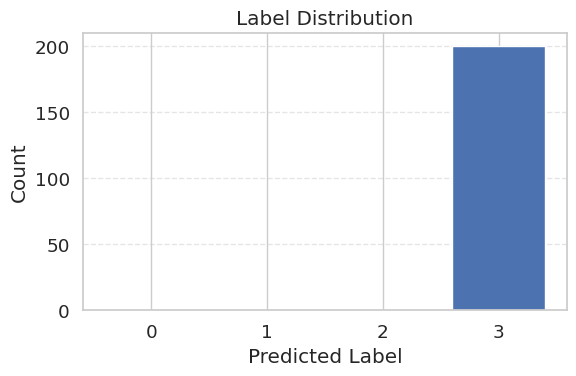

In [25]:
# Your list of tensors
probs_list = local_probs_new

# Step 1: Get predicted labels
labels_local = [torch.argmax(tensor).item() for tensor in probs_list]

# Step 2: Plot histogram
plt.figure(figsize=(6, 4))
plt.hist(labels_local, bins=range(5), align='left', rwidth=0.8)
plt.xlabel("Predicted Label")
plt.ylabel("Count")
plt.title("Label Distribution")
plt.xticks(range(4))  # Assuming labels are in range [0, 3]
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


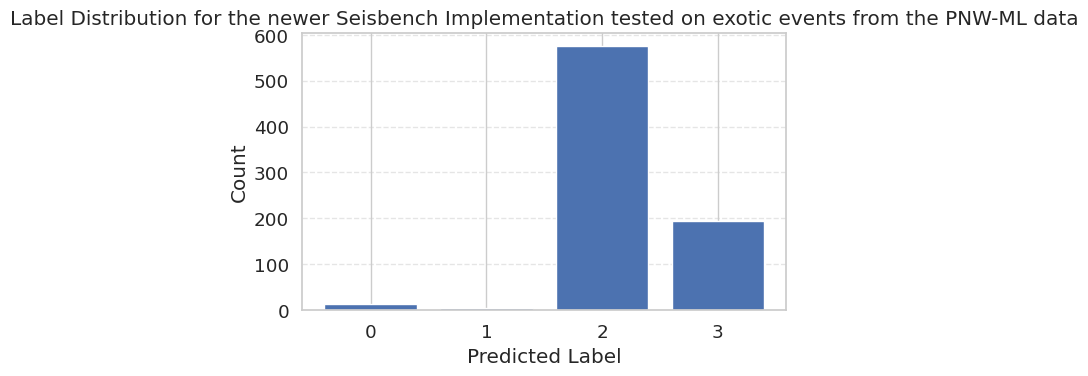

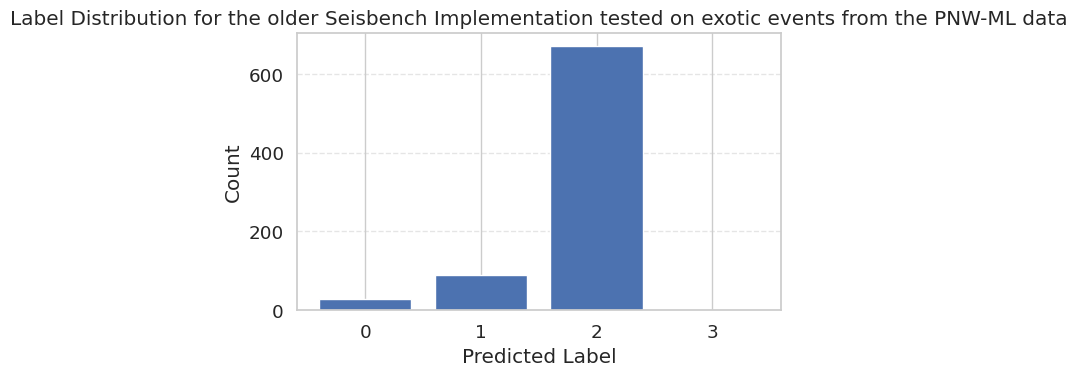

In [26]:
# Your list of tensors
probs_list = seisbench_probs_new
# Step 1: Get predicted labels
labels_seisbench_new = [torch.argmax(tensor).item() for tensor in probs_list]

# Step 2: Plot histogram
plt.figure(figsize=(6, 4))
plt.hist(labels_seisbench_new, bins=range(5), align='left', rwidth=0.8)
plt.xlabel("Predicted Label")
plt.ylabel("Count")
plt.title("Label Distribution for the newer Seisbench Implementation tested on exotic events from the PNW-ML data")
plt.xticks(range(4))  # Assuming labels are in range [0, 3]
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



# Your list of tensors
probs_list = seisbench_probs
# Step 1: Get predicted labels
labels_seisbench_old = [torch.argmax(tensor).item() for tensor in probs_list]

# Step 2: Plot histogram
plt.figure(figsize=(6, 4))
plt.hist(labels_seisbench_old, bins=range(5), align='left', rwidth=0.8)
plt.xlabel("Predicted Label")
plt.ylabel("Count")
plt.title("Label Distribution for the older Seisbench Implementation tested on exotic events from the PNW-ML data")
plt.xticks(range(4))  # Assuming labels are in range [0, 3]
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [27]:
import numpy as np
import torch
from scipy import signal

# Matching parameters
fs = 100
nperseg = 256
overlap = 0.5
noverlap = int(nperseg * overlap)
hop_length = nperseg - noverlap

# Create dummy waveform data similar to (B, C, T)
np.random.seed(0)
wave_np = np.random.randn(2, 3, 2048).astype(np.float32)
wave_torch = torch.tensor(wave_np)

# Scipy version
def extract_spectrograms_scipy(waveforms, fs, nperseg=256, overlap=0.5):
    noverlap = int(nperseg * overlap)
    f, t, Sxx = signal.spectrogram(waveforms[0, 0], nperseg=nperseg, noverlap=noverlap, fs=fs)
    spectrograms = np.zeros((waveforms.shape[0], waveforms.shape[1], len(f), len(t)))

    for i in range(waveforms.shape[0]):
        for j in range(waveforms.shape[1]):
            _, _, Sxx = signal.spectrogram(waveforms[i, j], nperseg=nperseg, noverlap=noverlap, fs=fs, scaling='density', mode='psd')
            spectrograms[i, j] = Sxx

    return spectrograms

# PyTorch version (modified)
def extract_spectrograms_torch(waveforms, fs, nperseg=256, overlap=0.5):
    noverlap = int(nperseg * overlap)
    hop_length = nperseg - noverlap

    window = torch.hann_window(nperseg, dtype=waveforms.dtype, device=waveforms.device)
    spec = []
    for i in range(waveforms.shape[0]):
        comps = []
        for j in range(waveforms.shape[1]):
            Sxx = torch.stft(
                waveforms[i, j],
                n_fft=nperseg,
                hop_length=hop_length,
                win_length=nperseg,
                window=window,
                center=False,
                return_complex=True,
                normalized=False,
            )
            power = (torch.abs(Sxx) ** 2) / (fs * (window ** 2).sum())
            comps.append(power)
        spec.append(torch.stack(comps))
    return torch.stack(spec).numpy()

# Run both versions
spec_scipy = extract_spectrograms_scipy(wave_np, fs, nperseg, overlap)
spec_torch = extract_spectrograms_torch(wave_torch, fs, nperseg, overlap)

# Compare numerically
difference = np.abs(spec_scipy - spec_torch).mean()
difference_max = np.abs(spec_scipy - spec_torch).max()

difference, difference_max


(0.01094126606634296, 0.11320343613624573)

/tmp/ipykernel_165984/2598936444.py:35: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/ak287/miniconda3/envs/surface/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


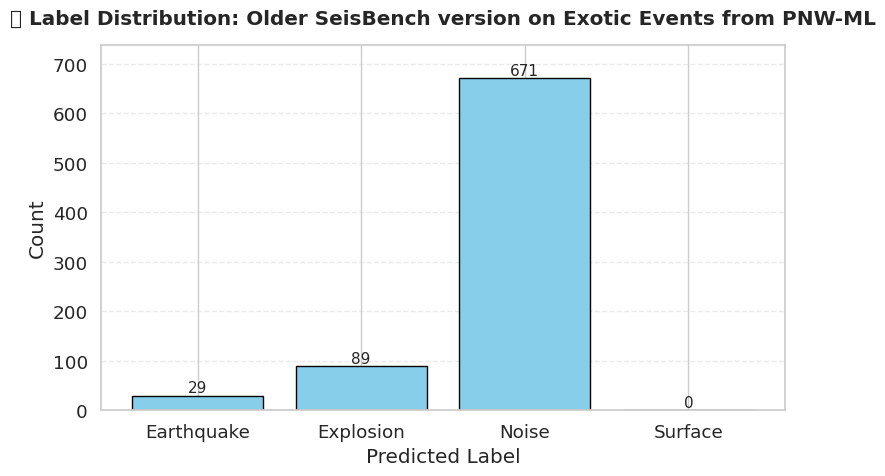

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# Assume probs_list is already defined
labels_seisbench_old = [torch.argmax(tensor).item() for tensor in probs_list]

# Use Seaborn style
sns.set(style="whitegrid", font_scale=1.2)

# Define class names if available
class_names = ['Earthquake', 'Explosion', 'Noise', 'Surface']  # adjust if needed
num_classes = len(class_names)

# Count frequency of each label
counts = [labels_seisbench_old.count(i) for i in range(num_classes)]

# Plot
plt.figure(figsize=(8, 5))
bars = plt.bar(range(num_classes), counts, tick_label=class_names, color='skyblue', edgecolor='black')

# Annotate bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 1, f'{height}', ha='center', va='bottom', fontsize=11)

# Add labels and title
plt.xlabel("Predicted Label")
plt.ylabel("Count")
plt.title("📊 Label Distribution: Older SeisBench version on Exotic Events from PNW-ML", pad=15, weight='bold')
plt.ylim(0, max(counts) * 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.4)

# Tidy layout
plt.tight_layout()
plt.show()


/tmp/ipykernel_165984/1155447537.py:33: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/ak287/miniconda3/envs/surface/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


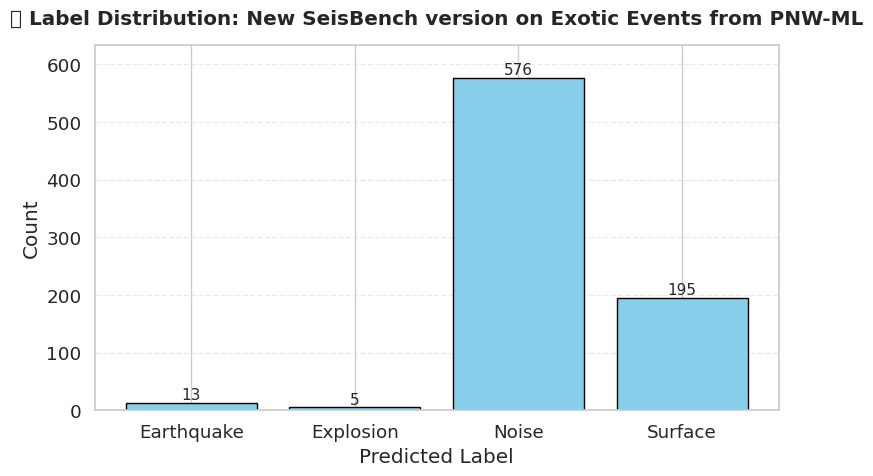

In [29]:
probs_list = seisbench_probs_new

# Assume probs_list is already defined
labels_seisbench_new = [torch.argmax(tensor).item() for tensor in probs_list]

# Use Seaborn style
sns.set(style="whitegrid", font_scale=1.2)

# Define class names if available
class_names = ['Earthquake', 'Explosion', 'Noise', 'Surface']  # adjust if needed
num_classes = len(class_names)

# Count frequency of each label
counts = [labels_seisbench_new.count(i) for i in range(num_classes)]

# Plot
plt.figure(figsize=(8, 5))
bars = plt.bar(range(num_classes), counts, tick_label=class_names, color='skyblue', edgecolor='black')

# Annotate bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 1, f'{height}', ha='center', va='bottom', fontsize=11)

# Add labels and title
plt.xlabel("Predicted Label")
plt.ylabel("Count")
plt.title("📊 Label Distribution: New SeisBench version on Exotic Events from PNW-ML", pad=15, weight='bold')
plt.ylim(0, max(counts) * 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.4)

# Tidy layout
plt.tight_layout()
plt.show()

